In [536]:
from PIL import Image
from wand.image import Image as wandImage
from wand.color import Color
from mrjob.job import MRJob
import cv2
import csv
import PyPDF2
import pytesseract
import argparse
import io
import numpy as np
import pandas as pd
import tempfile
import pickle
import boto3
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import itertools
import intervals
%matplotlib inline

def pdfPageToImg(src_pdf, pagenum, resolution=300, preprocess="thresh"):

    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))
    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    img_buffer=None

    with wandImage(file = pdf_bytes, resolution = resolution) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    return gray
    #return Image.fromarray(gray)

def categorizeTwoColumnBlocks(contents):
    blockstats = contents['blockstats']
    paragraphs = contents['paragraphs']
    data = contents['data']
    boxes = contents['boxes']
    
    header = blockstats[(blockstats.bottom_at < blockstats.bottom_at.max()*0.1) & (blockstats.n_par < 2)].sort_values(by='left_at')
    leftcol = blockstats[(blockstats.right_at < blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='left_at')
    rightcol = blockstats[(blockstats.right_at > blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='top_at')
    footer = blockstats[(blockstats.top_at > blockstats.bottom_at.max()*0.9) & (blockstats.n_par < 2)].sort_values(by='top_at')

    blocks = {'header':header,'footer':footer,'leftcol':leftcol,'rightcol':rightcol}

    paragraphs = {'header':list(itertools.chain.from_iterable([paragraphs[i] for i in header.index])),
                  'footer':list(itertools.chain.from_iterable([paragraphs[i] for i in footer.index])),
                  'leftcol':list(itertools.chain.from_iterable([paragraphs[i] for i in leftcol.index])),
                  'rightcol':list(itertools.chain.from_iterable([paragraphs[i] for i in rightcol.index]))
                 }

    mergedblocks = {}
    for k in blocks.keys():
        summary = {}
        summary['top_at'] = blocks[k].top_at.min()
        summary['bottom_at'] = blocks[k].bottom_at.max()
        summary['left_at'] = blocks[k].left_at.min()
        summary['right_at'] = blocks[k].right_at.max()
        summary['width'] = summary['right_at'] - summary['left_at']
        summary['height'] = summary['bottom_at'] - summary['top_at']
        mergedblocks[k] = summary
    
    return {'mergedblocks':mergedblocks,
            'blockstats':blocks,
            'paragraphs':paragraphs,
            'data':data,
            'boxes':boxes
           }

def drawBlocks(gray, pagecontents, preprocess="thresh"):

    blockstats = pagecontents['blockstats']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    return img_blocks
        
def drawMergedBlocks(gray, pagecontents, preprocess="thresh"):

    mergedblocks = pagecontents['mergedblocks']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in mergedblocks.items():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)
        
    return img_blocks

def loadAllData(contentsFile, pdfFile):
    contents = pickle.load( open( contentsFile, "rb" ) )
    src_pdf = PyPDF2.PdfFileReader(pdfFile)
    return {'contents': contents, 'pdf': src_pdf}

def findIntervals(row, direction = 0):
    if direction == 0:
        return pd.Interval(left=row['top_at'], right=row['bottom_at'], closed='both')
    else:
        return pd.Interval(left=row['left_at'], right=row['right_at'], closed='both')

def pageBlockIntervals(contents, direction=0):
    return contents.apply(lambda row: findIntervals (row, direction),axis=1)

def mergeIntervals(intv):
    # 1. Sort the intervals based on increasing order of starting time.
    # 2. Push the first interval onto the stack.
    # 3. For each interval:
    #    a. If the current interval does not overlap with the top of the stack, push it.
    #    b. If the current interval overlaps with stack top and the ending time of the current
    #        interval is more than that of stack top, update stack top with the ending time of the current interval.
    # 4. When complete, the stack contains the merged intervals. 
    intvlist = list(intv.sort_values())
    stack = []
    stack.append(intvlist.pop(0))
    for i in range(len(intvlist)):
        int_1 = stack.pop()
        int_2 = intvlist[i]
        int_1i = intervals.closed(int_1.left, int_1.right) # pandas 0.23
        int_2i = intervals.closed(int_2.left, int_2.right) # pandas 0.23
        if int_1i.overlaps(int_2i):  # pandas 0.23
#        if int_1.overlaps(int_2):  # pandas 0.24, when 'overlaps' becomes available
            stack.append(pd.Interval(left=int_1.left, right=max(int_1.right, int_2.right),
                                     closed='both'))
        else:
            stack.append(int_1)
            stack.append(int_2)
    return stack

def findSection(section, blocks, bounds):
    block = None
    int_1 = section[bounds]
    int_1i = intervals.closed(int_1.left, int_1.right) # pandas 0.23
    for i in range(len(blocks)):
        int_2 = blocks.iloc[i][bounds]
        int_2i = intervals.closed(int_2.left, int_2.right) # pandas 0.23       
        if int_2i.contains(int_1i): # pandas 0.23 intervals does not have 'contains' method
#        if int_2.contains(int_1): # for when 'contains' becomes available in pandas
            block = blocks.iloc[i].name
    return block
    
def addSectionAssignment(blockdefs):
    blockstats = blockdefs
    vblocks = pd.DataFrame(pageBlockIntervals(blockstats), columns=["ybounds"])
    vsections = pd.DataFrame(mergeIntervals(vblocks['ybounds']), columns=["ybounds"])
    vsections.index.name = "vsection"
    blockstats['vsection'] = pd.Categorical(vblocks.apply(lambda row: findSection (row, vsections, 'ybounds'),axis=1))

    sdf = []
    for section in vsections.index:
        blocks = blockstats[blockstats.vsection==section]
        blks = pd.DataFrame(pageBlockIntervals(blocks, direction=1), columns=["xbounds"])
        sect = pd.DataFrame(mergeIntervals(blks['xbounds']), columns=["xbounds"])
        sect['hsection'] = sect.index
        sect['vsection'] = section
        blockstats.loc[blockstats.vsection==section,'hsection'] = pd.Categorical(blks.apply(lambda row: findSection (row, sect, 'xbounds'),axis=1))
        sdf.append(sect)

    sections = pd.merge(pd.concat(sdf), vsections, how='inner', on='vsection')[['vsection','hsection','xbounds','ybounds']]
    sections.set_index(['vsection','hsection'], inplace=True)
        
    return {'blockstats':blockstats, 'sections':sections }

def outlineSections(img, pagecontents):

    sections = pagecontents['sections']

    h, w = img.shape
    img_blocks = img.copy()
    for idx, row in sections.iterrows():
        top_left = (row['xbounds'].left, row['ybounds'].left)
        bottom_right = (row['xbounds'].right, row['ybounds'].right)
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)
        
    return img_blocks

In [561]:
data = loadAllData(contentsFile="/Users/matt/Projects/ocr/1863Langley/1863contents.p",
                   pdfFile="/Users/matt/Projects/ocr/1863Langley/1863Langley.pdf")

In [563]:
for pagenum in range(len(data['contents'])):
    try:
        height = []
        width = []
        midx = []
        midy = []
        cont = addSectionAssignment(data['contents'][pagenum]['blockstats'])
        blockstats = cont['blockstats']
        blockstats['width'] = blockstats.right_at - blockstats.left_at
        blockstats['height'] = blockstats.bottom_at - blockstats.top_at
        sections = cont['sections']
        for idx, row in sections.iterrows():
            width.append(row['xbounds'].right - row['xbounds'].left)
            height.append(row['ybounds'].right - row['ybounds'].left)
            midx.append(row['xbounds'].left + (row['xbounds'].right - row['xbounds'].left)/2)
            midy.append(row['ybounds'].left + (row['ybounds'].right - row['ybounds'].left)/2)
        sections['width'] = width
        sections['height'] = height        
        sections['midx'] = midx
        sections['midy'] = midy        
        data['contents'][pagenum]['sections'] = sections
    except:
        blockstats = data['contents'][pagenum]['blockstats']
        data['contents'][pagenum]['sections'] = []
    data['contents'][pagenum]['blockstats'] = blockstats

In [ ]:
# We know that the directory spans pages 123-469 (p.122 is the title page of the directory, with some names)
isdirectory = [False]*len(pageimages.sequence)
for i in range(123, 469):
    isdirectory[i] = True

## Workspace

width  height    midx    midy  page
vsection hsection                                     
1        0           681    2237   425.5  1305.5   124
         1           676    2237  1130.0  1305.5   124
         0           674    2232   392.0  1278.0   125
         1           677    2232  1093.5  1278.0   125
         0           685    2234   407.5  1289.0   127
         1           679    2234  1116.5  1289.0   127
         0           685    2239   395.5  1268.5   128
         1           683    2239  1102.5  1268.5   128
         0           679    2234   424.5  1298.0   129
         1           679    2234  1130.5  1298.0   129
2        0           697    2237   386.5  1272.5   130
         1           689    2237  1085.5  1272.5   130
1        0           683    2234   405.5  1286.0   131
         1           678    2234  1110.0  1286.0   131
         0           687    2230   410.5  1285.0   133
         1           700    2230  1114.0  1285.0   133
         0           690    2240   420.0  1268.0   134
         1           686    2240  1129.0  1268.0   134
         0           698    2240   416.0  1291.0   136
         1           688    2240  1133.0  1291.0   136
         0           691    2225   387.5  1293.5   137
         1           682    2225  1090.0  1293.5   137
         0           691    2239   434.5  1273.5   138
         1           687    2239  1141.5  1273.5   138
         0           693    2237   382.5  1281.5   139
         1           694    2237  1088.0  1281.5   139
         0           685    2241   392.5  1272.5   140
         1           698    2241  1109.0  1272.5   140
         0           693    2235   400.5  1289.5   141
         1           683    2235  1112.5  1289.5   141
...                  ...     ...     ...     ...   ...
         0           683    2237   409.5  1275.5   450
         1           699    2237  1124.5  1275.5   450
         0           683    2226   407.5  1267.0   453
         1           688    2226  1110.0  1267.0   453
         0           684    2235   412.0  1262.5   454
         1           694    2235  1127.0  1262.5   454
         0           682    2229   388.0  1274.5   455
         1           683    2229  1090.5  1274.5   455
         0           684    2239   421.0  1267.5   456
         1           683    2239  1129.5  1267.5   456
         0           698    2249   386.0  1267.5   457
         1           681    2249  1100.5  1267.5   457
         0           686    2236   416.0  1275.0   458
         1           699    2236  1117.5  1275.0   458
         0           677    2224   396.5  1269.0   459
         1           680    2224  1102.0  1269.0   459
2        0           701    2247   435.5  1274.5   460
         1           692    2247  1138.0  1274.5   460
1        0           675    2232   395.5  1266.0   461
         1           679    2232  1098.5  1266.0   461
         0           683    2243   411.5  1275.5   462
         1           683    2243  1120.5  1275.5   462
         0           678    2235   391.0  1280.5   463
         1           683    2235  1094.5  1280.5   463
         0           684    2249   391.0  1276.5   464
         1           687    2249  1102.5  1276.5   464
         0           684    2247   391.0  1259.5   466
         1           685    2247  1098.5  1259.5   466
         0           690    2240   415.0  1274.0   468
         1           689    2240  1121.5  1274.0   468

[517 rows x 5 columns]

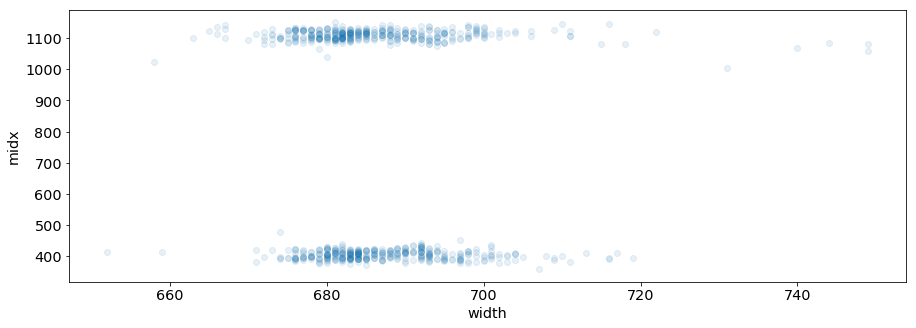

In [576]:
dataset = []
for pagenum in range(len(data['contents'])):
    cont = data['contents'][pagenum]['sections']
    try:
        dat = cont.loc[:,['width','height','midx','midy']]
        dat['page'] = pagenum
        dataset.append(dat)
    except:
        None

ds = pd.concat(dataset)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)


fig = plt.figure()
ds_full = ds
ds = ds_full.loc[(ds_full['width'] > 650) & (ds_full['width'] < 750) &
                                             ((ds_full['midx'] > 900) | (ds_full['midx'] < 500))]
plt.scatter(ds['width'],ds['midx'], alpha=0.1)
# fig.suptitle('test title', fontsize=20)
plt.xlabel('width')
plt.ylabel('midx')

ds[(ds['page'] < 469) & (ds['page'] > 122) ]

In [548]:
data['contents'][342]['sections']

xbounds       ybounds  width  height    midx    midy
vsection hsection                                                          
0        0         [263, 1176]      [52, 97]    913      45   719.5    74.5
1        0           [52, 749]   [139, 2377]    697    2238   400.5  1258.0
         1          [751, 764]   [139, 2377]     13    2238   757.5  1258.0
         2         [769, 1459]   [139, 2377]    690    2238  1114.0  1258.0
2        0         [110, 1399]  [2418, 2476]   1289      58   754.5  2447.0

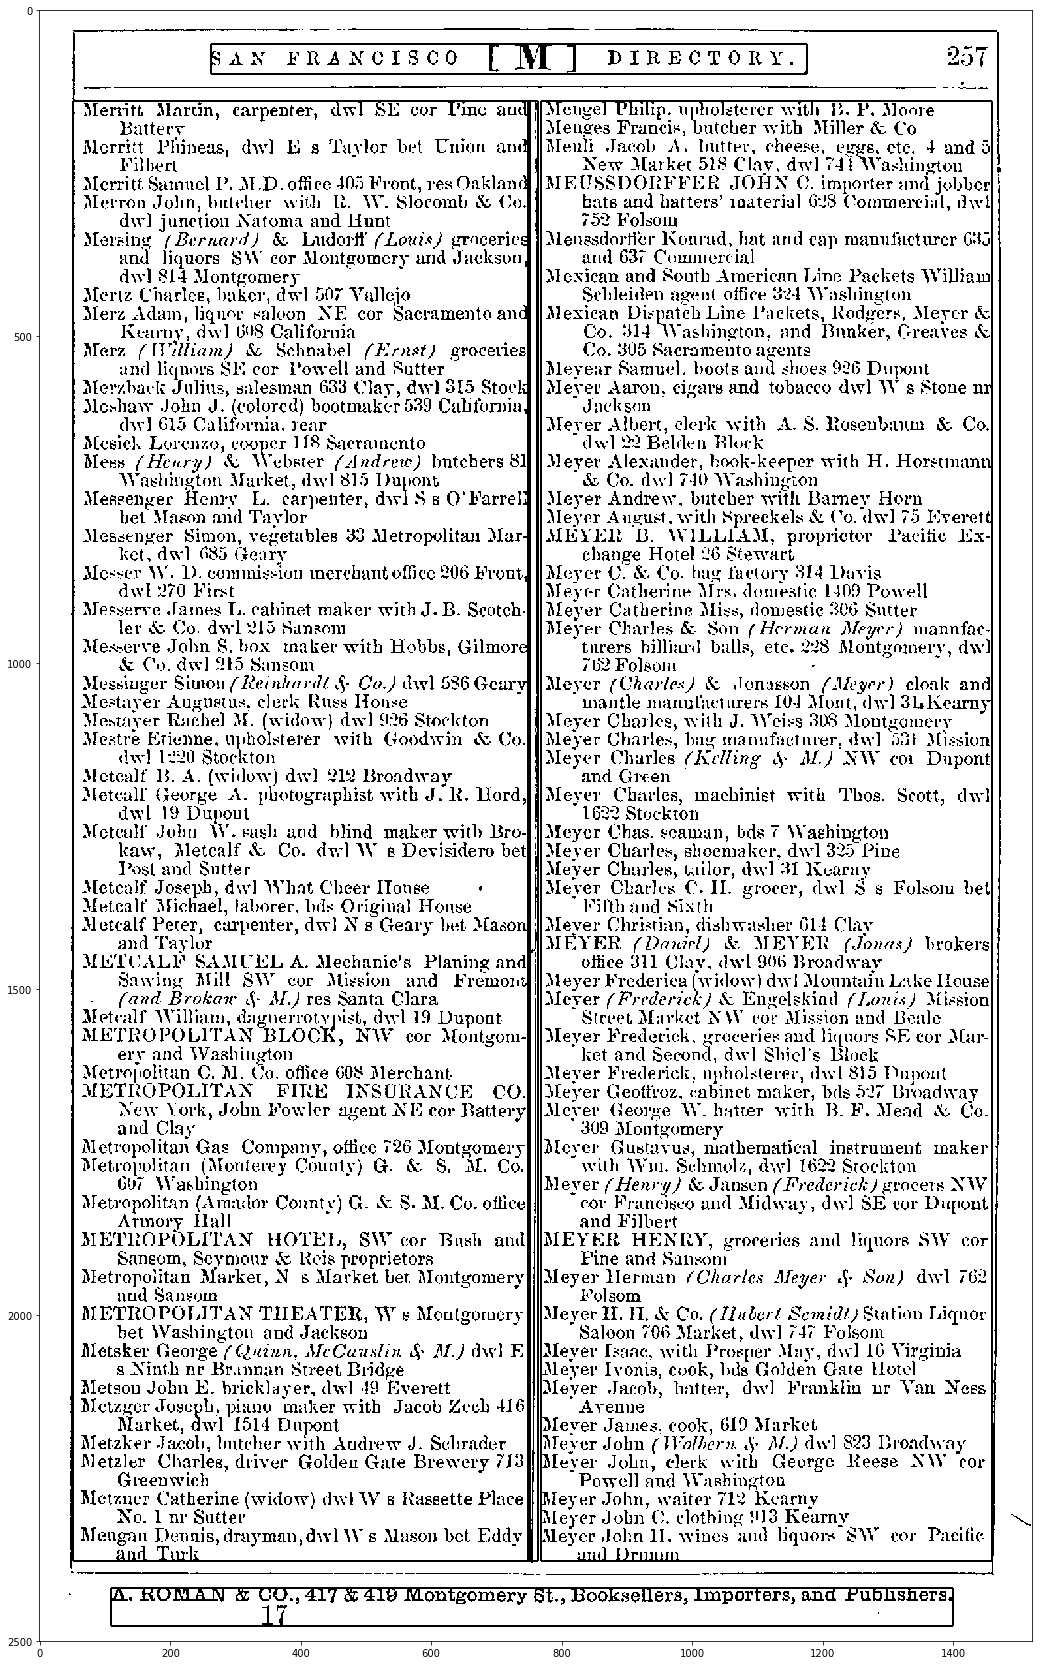

In [504]:
pagenum = 342
img = pdfPageToImg(data['pdf'], pagenum)
plt.rcParams["figure.figsize"] = (50,30)
try:
    img_blocks = outlineSections(img, data['contents'][pagenum])
except:
    img_blocks = drawBlocks(img, data['contents'][pagenum])
plt.imshow(img_blocks,cmap='gray')
plt.show()

 1. Determine whether a page is of a 'two-column' format (e.g., p.342)
 2. Identify blocks that are the components of this format (e.g., p. 342, blocks 4 and 9 are columns, block 2 is the header and block 12 is the footer).
 3. Find erroneous blocks (e.g., p.342, block 6, containing a single '|').
 4. Fix improperly parsed blocks (e.g., p.342 block 4 needs re-parsing into paragraphs).